In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [ ]:
# import data

train = pd.read_csv('/min_train.csv')
val = pd.read_csv('/min_val.csv')
test = pd.read_csv('/min_test.csv')
test2 = pd.read_csv('/min_test2.csv')

In [ ]:
train_mp = train['Mid_Price']
val_mp = val['Mid_Price']
test_mp = test['Mid_Price']
test2_mp = test2['Mid_Price']

In [ ]:
# normalising

train_mean = train_mp.mean()
train_std = train_mp.std()

train_nr = (train_mp - train_mean)/train_std
val_nr = (val_mp - train_mean)/train_std
test_nr = (test_mp - train_mean)/train_std

In [ ]:
def create_sequences(data, input_sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + input_sequence_length)])
        y.append(data[(i + input_sequence_length):(i + input_sequence_length + forecast_horizon)])
    return np.array(X), np.array(y)

In [ ]:
input_sequence_length = 20
forecast_horizon = 5

X_train, y_train = create_sequences(train_nr, input_sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_nr, input_sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_nr, input_sequence_length, forecast_horizon)

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42293, 20), (42293, 5), (10176, 20), (10176, 5), (10686, 20), (10686, 5))

In [ ]:
# change the shape to fit the LSTM model

X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]


y_train = y_train[:, :, np.newaxis]
y_val = y_val[:, :, np.newaxis]
y_test = y_test[:, :, np.newaxis]

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42293, 20, 1),
 (42293, 5, 1),
 (10176, 20, 1),
 (10176, 5, 1),
 (10686, 20, 1),
 (10686, 5, 1))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = train_dataset.batch(32)

val_dataset = val_dataset.batch(32)

test_dataset = test_dataset.batch(32)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:


OUT_STEPS = 5
num_features = 1

In [ ]:
def build_model(hp):
    model = Sequential([
        layers.LSTM(
            units=hp.Int('units', min_value=50, max_value=300, step=50),
            input_shape=(20, 1)  # Assuming input_shape is always (20, 1)
        ),
        layers.Dense(
            OUT_STEPS * num_features,
            kernel_initializer=tf.initializers.zeros()
        ),
        layers.Reshape([OUT_STEPS, num_features])
    ])

    model.compile(
        loss='mse',
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        metrics=['mean_absolute_percentage_error']
    )
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',  # Targeting to minimize the validation loss
    max_trials=10,  # Number of trials to run (different model configurations)
    executions_per_trial=1,
    directory='my_dir2',
    project_name='lstm_tuning'
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(
    X_train, y_train,  # assuming x_train and y_train are prepared
    epochs=50,
    validation_split=0.2,  # 20% of the data for validation
    callbacks=[stop_early]
)

Trial 10 Complete [00h 06m 29s]
val_loss: 0.017966069281101227

Best val_loss So Far: 0.01760111190378666
Total elapsed time: 00h 57m 52s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dense (Dense)               (None, 5)                 1505      
                                                                 
 reshape (Reshape)           (None, 5, 1)              0         
                                                                 
Total params: 363905 (1.39 MB)
Trainable params: 363905 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def plot_results(X_train,X_val,X_test,y_train,y_val,y_test, model):
    # Creating indices for plotting
    train_x = np.arange(len(y_train))
    val_x = np.arange(len(y_val))
    test_x = np.arange(len(y_test))

    # Making predictions
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # Creating a figure and subplots
    plt.figure(figsize=(20, 15))  # Adjusted for better vertical display

    # Subplot for the training set
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(train_x, y_train[:, 0], label='Actual')
    plt.plot(train_x, pred_train[:, 0], label='Predicted')
    plt.title('Training Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the validation set
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(val_x, y_val[:, 0], label='Actual')
    plt.plot(val_x, pred_val[:, 0], label='Predicted')
    plt.title('Validation Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the test set
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(test_x, y_test[:, 0], label='Actual')
    plt.plot(test_x, pred_test[:, 0], label='Predicted')
    plt.title('Test Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

334/334 [==============================] - 6s 17ms/step


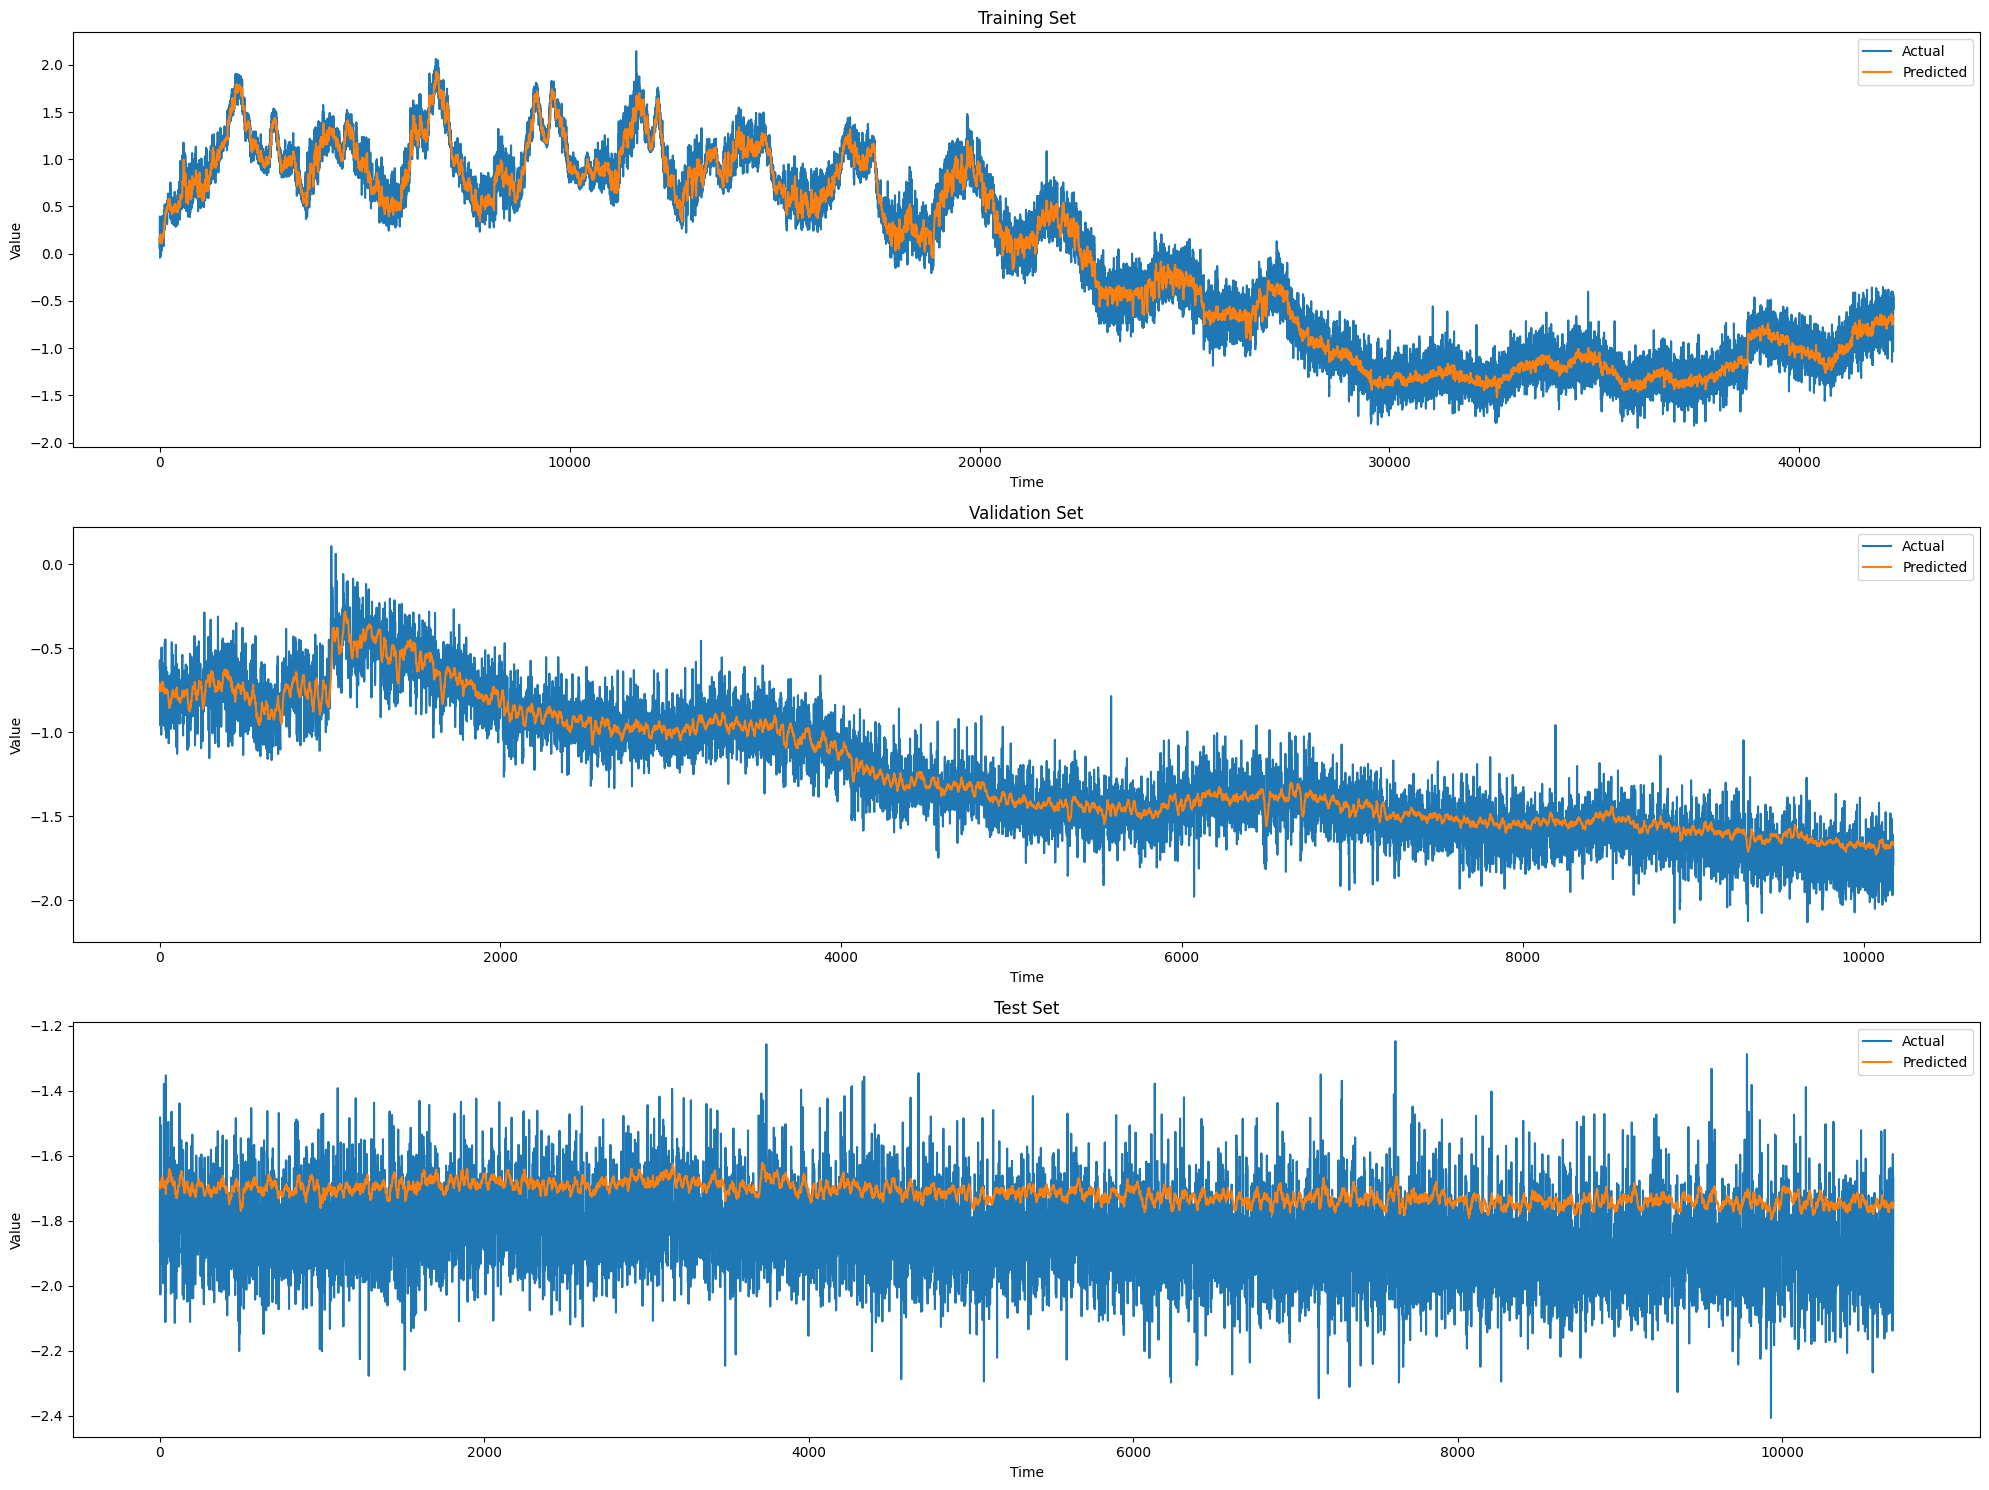

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, best_model)

## Try different number of layers (1 to 4)

In [77]:
def build_model4(hp):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(20, 1)))  # Assuming input shape is (20, 1)

    # Tuning the number of LSTM layers
    for i in range(hp.Int('num_layers', 1, 4)):  # Let's say we want between 1 and 4 LSTM layers
        model.add(layers.LSTM(units=hp.Int('units_' + str(i), min_value=10, max_value=300, step=10),
                       return_sequences=True if i < hp.get('num_layers') - 1 else False))

    model.add(layers.Dense(
            OUT_STEPS * num_features,
            kernel_initializer=tf.initializers.zeros()
        )),
    model.add(layers.Reshape([OUT_STEPS, num_features]))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )
    return model

In [78]:
tuner4 = RandomSearch(
    build_model4,
    objective='val_loss',  # Targeting to minimize the validation loss
    max_trials=10,  # Number of trials to run (different model configurations)
    executions_per_trial=1,
    directory='my_dir6',
    project_name='lstm_tuning_2'
)

In [79]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [1]:
tuner4.search(
    X_train, y_train,  # assuming x_train and y_train are prepared
    epochs=50,
    validation_split=0.2,  # 20% of the data for validation
    callbacks=[stop_early]
)

NameError: name 'tuner4' is not defined